In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%config InlineBackend.figure_format = 'retina'
from DS_detector import rematch_cat
from DS_models_stat import cut_cat

In [9]:
#df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8.csv')
df = rematch_cat('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8.csv', tp_dist=400/3600, add_fn=True)
#df = rematch_cat('/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.00.csv', tp_dist=400/3600)
#df = rematch_cat('/home/rt2122/Data/SRGz/brcat.csv', tp_dist=400/3600) 
name='SZcat(AL)'
#name='SZcat(gen)'
#name='brcat'

df = cut_cat(df, dict_cut={'b' : [20, np.inf], 'l' : [0, 180]}) 

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
df = df[df['status'] != 'fp']
df = df[df['catalog'] != 'planck_no_z']
df.index = np.arange(len(df))

In [11]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
q_m = [df['M500'].quantile(i/10) for i in range(0, 11)]
q_m[0] = 0
q_m[-1] = 20
print(repr(q_z))
print(repr(q_m))

[0, 0.13224999999999995, 0.2427999973297117, 0.35854775, 0.4994, 0.6759642912261963, 2]
[0, 1.02035, 1.5514474635210362, 1.8049544286288828, 2.074912, 2.368595908964793, 2.6636401193884973, 3.0171712446820025, 3.592052, 4.814171, 20]


In [12]:
q_m500 = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_m500[en] = [cur_df['M500'].quantile(i / 10) for i in range(11)]
    q_m500[en][-1] = 20


In [13]:
q_m500 = pd.DataFrame(q_m500)
q_m500

,0.132250,0.242800,0.358548,0.499400,0.675964,2.000000
0,0.009600,0.243700,0.324500,0.593800,0.958000,1.087900
1,0.284160,0.886340,1.289300,1.548246,1.680914,1.621790
2,0.462320,1.399969,1.554017,1.831485,1.887300,1.768002
3,0.730080,1.705994,1.903761,2.132499,2.110007,1.941338
4,1.026520,2.087605,2.206282,2.382499,2.395807,2.086889
5,1.385900,2.508941,2.524360,2.605593,2.637179,2.293961
6,1.754260,2.944524,2.948684,2.820298,2.845264,2.543554
7,2.167288,3.475085,3.805668,3.168335,3.106554,2.843697
8,2.570124,4.042076,4.670624,3.903347,3.395224,3.170955
9,3.222908,4.877764,5.617369,5.507178,4.933466,3.750020


In [14]:
recalls = []
for j in range(len(q_m500[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        recall = np.count_nonzero(cur_df['status'] == 'tp') / len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = recall
    recalls.append(pd.DataFrame(line, index=[j]))
recalls = pd.concat(recalls)

In [15]:
recalls

,"(0.00,0.13)","(0.13,0.24)","(0.24,0.36)","(0.36,0.50)","(0.50,0.68)","(0.68,2.00)"
0,0.045455,0.000000,0.045455,0.069767,0.090909,0.068182
1,0.023256,0.093023,0.116279,0.162791,0.093023,0.000000
2,0.046512,0.232558,0.209302,0.139535,0.046512,0.023256
3,0.116279,0.255814,0.116279,0.093023,0.068182,0.069767
4,0.348837,0.232558,0.380952,0.186047,0.116279,0.069767
5,0.477273,0.465116,0.288889,0.162791,0.209302,0.090909
6,0.744186,0.744186,0.488372,0.302326,0.090909,0.142857
7,0.813953,0.860465,0.906977,0.441860,0.116279,0.159091
8,0.767442,0.976744,0.883721,0.674419,0.279070,0.232558
9,0.863636,1.000000,0.977273,1.000000,0.954545,0.522727


In [16]:
cm = sns.light_palette("green", as_cmap=True)

s = recalls.style.background_gradient(cmap=cm)
s

,"(0.00,0.13)","(0.13,0.24)","(0.24,0.36)","(0.36,0.50)","(0.50,0.68)","(0.68,2.00)"
0,0.045455,0.000000,0.045455,0.069767,0.090909,0.068182
1,0.023256,0.093023,0.116279,0.162791,0.093023,0.000000
2,0.046512,0.232558,0.209302,0.139535,0.046512,0.023256
3,0.116279,0.255814,0.116279,0.093023,0.068182,0.069767
4,0.348837,0.232558,0.380952,0.186047,0.116279,0.069767
5,0.477273,0.465116,0.288889,0.162791,0.209302,0.090909
6,0.744186,0.744186,0.488372,0.302326,0.090909,0.142857
7,0.813953,0.860465,0.906977,0.441860,0.116279,0.159091
8,0.767442,0.976744,0.883721,0.674419,0.279070,0.232558
9,0.863636,1.000000,0.977273,1.000000,0.954545,0.522727


In [17]:
nums = []
for j in range(len(q_m500) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        num = len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = num
    nums.append(pd.DataFrame(line, index=[j]))
nums = pd.concat(nums)

In [18]:
nums

,"(0.00,0.13)","(0.13,0.24)","(0.24,0.36)","(0.36,0.50)","(0.50,0.68)","(0.68,2.00)"
0,44,44,44,43,44,44
1,43,43,43,43,43,43
2,43,43,43,43,43,43
3,43,43,43,43,44,43
4,43,43,42,43,43,43
5,44,43,45,43,43,44
6,43,43,43,43,44,42
7,43,43,43,43,43,44
8,43,43,43,43,43,43
9,44,44,44,44,44,44


In [19]:
nums = []
for j in range(len(q_m) - 1):
    line = {}
    m_st = q_m[j]
    m_en = q_m[j + 1]
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        num = len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = num
    nums.append(pd.DataFrame(line, index=['({:.2f},{:.2f})'.format(m_st, m_en)]))
nums = pd.concat(nums)

In [20]:
nums

,"(0.00,0.13)","(0.13,0.24)","(0.24,0.36)","(0.36,0.50)","(0.50,0.68)","(0.68,2.00)"
"(0.00,1.02)",170,54,29,6,1,0
"(1.02,1.55)",69,54,57,40,14,23
"(1.55,1.80)",29,33,35,36,55,74
"(1.80,2.07)",28,30,33,43,54,71
"(2.07,2.37)",26,36,39,46,47,66
"(2.37,2.66)",33,24,41,62,56,43
"(2.66,3.02)",29,34,28,55,67,46
"(3.02,3.59)",20,43,36,40,64,57
"(3.59,4.81)",19,78,59,41,30,33
"(4.81,20.00)",10,46,76,62,46,20


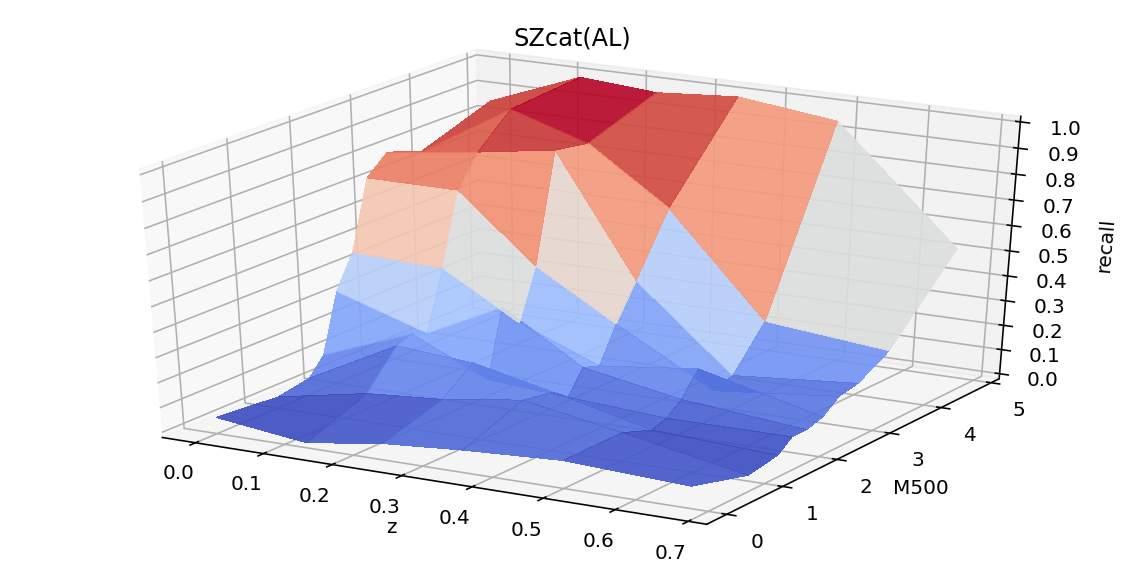

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(recalls)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = recalls[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_zlabel('recall')
#ax.set_ylabel('M500, M☉ * 10¹⁴')
ax.set_ylabel('M500')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title(name)
plt.show()